# 1.5.1 [Narrative Analytics & Experimentation Capstone](https://courses.thinkful.com/data-201v1/project/1.5.1)

Propose and outline an experiment plan including:
* Analysis that highlights experimental hypothesis
* Rollout and implementation plan the experiment
* Evaluation plan that describes what constitutes success in this experiment

## Data Source
Avocado price dataset from [Kaggle](https://www.kaggle.com/neuromusic/avocado-prices) which sites the [Hass Avocado Board](http://www.hassavocadoboard.com/retail/volume-and-price-data). The dataset includes retail scan data for National retail volume (units) and price. The channels represented include: grocery, mass, club, drugstore, dollar store, and military outlet.

#### Relevant Features:
* date - Record date of weekly aggregates
* average_price - Average price of a single avocado whether sold in bags or individually
* type - Conventional or organic avocado
* region - The city, or region of the observation (all regions from within the US)
* total_volume - Total number of individual avocados sold



## Exploration
In previous [exploration](https://github.com/Eileenyc/thinkful/blob/master/in_search_of_affordable_avocados.ipynb) determined there is substantial difference in cost and demand for avocados regionally in the United States. 
However I was not able to examine how consumers respond to price changes for organic versus traditional avocados.

Distributions across the three year period suggested that there was a distinct difference in what customers were willing to pay for organic avocados compared to traditional avocados. In the scatterplots below we see that in 2015 there was a clear distinction between price for the two types. By 2017 there was considerably more overlap and certain regions like the Great Lakes seemed to experience this trend even more strongly.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

%matplotlib inline

In [5]:
# Import datasets
df_avo = pd.DataFrame(pd.read_csv('unit_1_data/avocado.csv',header=0, index_col=0))
df_pop = pd.DataFrame(pd.read_csv('unit_1_data/pop_us.csv',header=0))

# Standardize column names, remove spaces and capital letters
df_avo.columns = df_avo.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(
    '(', "").str.replace(')', '')
df_avo.rename(columns={'averageprice':'average_price', 'region':'region_name'}, inplace=True)
df_avo = df_avo[df_avo['year'] != 2018]
df_avo = pd.concat([df_avo.iloc[:,0:3], df_avo.iloc[:, -3:]],axis=1)
df_avo['date'] = pd.to_datetime(df_avo['date'])
df_avo['month'] = pd.to_datetime(df_avo['date']).dt.month

# Categorize add 
df_avo = df_avo.join(df_pop.set_index('region_name'), on='region_name', how='inner').reset_index(drop=True)
df_region = df_avo[df_avo['region_type']=='region'].reset_index(drop=True)

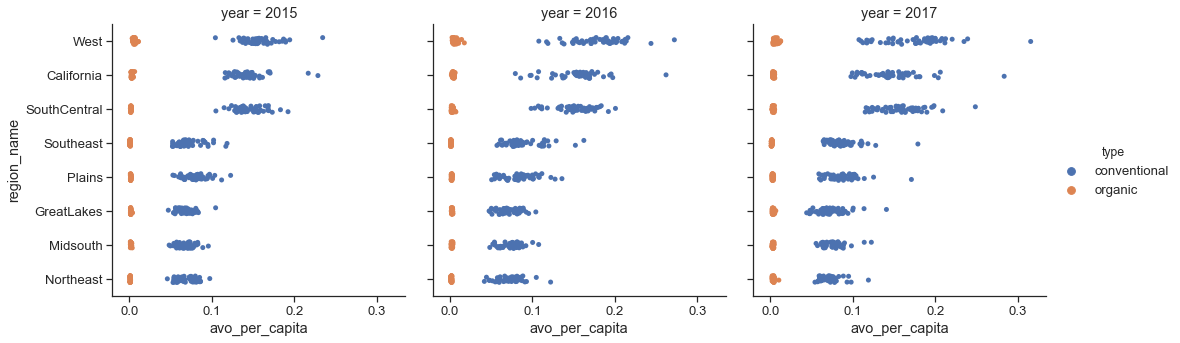

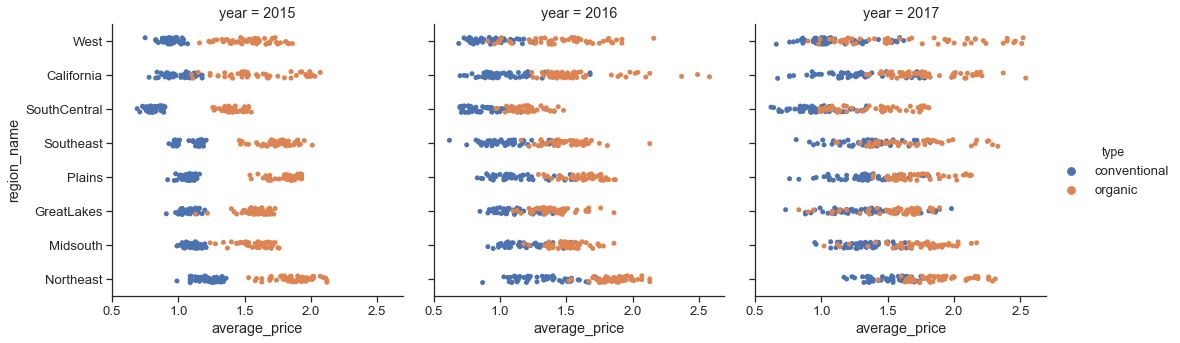

In [24]:
# Find Price Per capita
df_region['avo_per_capita'] = df_region.apply(lambda x: x.total_volume/x.est_pop, axis=1)
df_region = df_region.sort_values(by='avo_per_capita', ascending=False)

sns.set(style="ticks",font_scale=1.2, color_codes=True)
sns.catplot(x='avo_per_capita', y='region_name', data=df_region, hue='type', col='year')

sns.catplot(x='average_price', y='region_name', data=df_region, hue='type', col='year',)
plt.show()

## Experiment
I had previously hypothesized that grocery shoppers would be less sensitive to changes in organic avocado prices because organic produce is in many ways a luxury good. Consumers expect organic produce to be more expensive and those that are willing to pay the higher price will have a higher threshold before they stop purchasing. In the example above it looks like consumers in the Great Lakes are will to pay more for conventional avocados than some organic.

#### Hypothesis: 
In this specific experiment I'm sticking with my original hypothesize that grocery shoppers in the Great Lakes region will have greater flexibility in the price they are willing to pay for organic avocados than conventional avocados.

#### Procedure:
To test this, I will hold a closed bid auction in 2 grocery stores locations of similar quality (Heinen's is a local chain known for quality and affordability, this would be a good candidate as patrons of the store tend to be a cross section of socio-economic categories). The experiment would span 2 days in each location. On the first day subjects would be asked how much they would be willing to pay for a bag of conventional avocados and then how much they would pay for organic avocados. On the 2nd day a seperate group of trialists would be asked the same question in reverse. 

#### Evaluation:
After collecting the trials the relative elasticy would be simulated by counting the number of customers who listed a price that is above the clearing price or in this case the market price of the avocados. These rates of conventional and organic would then be compared using a t-test within each trial. An AA test of organic to organic and conventional to conventional could be executed across days or across grocery stores to make sure that the results are consistant. 

#### Potential bias:
* In any situation of naming prices a reference price will serve as an anchor to the respondant. This is why mutliple days are used with reverse order of avocado type. Hopefully this would reveal to what extent customers are anchoring their bids to previous price.
* In the current auction customers are not obligated to purchase the avocados at the price they list. There may be some difference in what they say they would spend compared to what they would actually spend. 

## Experiment Simulation

The simulation below demonstrates how the conventional and organic bids would be compared. The random normal distributions were set using Great Lake region's actual mean and standard deviation. After numerous runs of the simulation we see that a sample size of 100 will on most occasions be large enough to find statistically significant results.

In [25]:
great_lakes = df_region[df_region['region_name']=='GreatLakes'].reset_index(drop=True)
great_lakes.groupby('type').describe()['average_price']

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
conventional,157.0,1.184586,0.219622,0.73,1.04,1.12,1.32,1.98
organic,157.0,1.501720,0.196009,0.83,1.39,1.54,1.65,1.89


In [31]:
# I used mean & std from Great Lakes region to set mean and variance of sample
# size of sample
s = 100
bids_conv = np.random.normal(loc=1.18, scale=0.22,size=s)
bids_org = np.random.normal(loc=1.50, scale=0.19,size=s)

# Set clearing price for each group
clear_conv = 1.30
clear_org = 1.70

# Accept bids above clearing price
bids_conventional = bids_conv>=clear_conv
bids_organic = bids_org>=clear_org

# Compare bids above clearing price for conventional and organic avocados
tval,pval=stats.ttest_ind(bids_conventional, bids_organic)
print('tvalue: {}'.format(tval))
print('pvalue: {}'.format(pval))

tvalue: 2.872281323269015
pvalue: 0.004519230252214036
